<a href="https://colab.research.google.com/github/audreyemmely/pln/blob/main/pln_lista3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resolução Lista 3**

---

Audrey Emmely Rodrigues Vasconcelos

Karen Nayara Gomes da Silva

In [1]:
#from google.colab import files
#uploaded = files.upload()
#upando train_data e test_data_solution

###### Questão 1
Escolha 10 documentos da base, e determine seu documento mais parecido
(que não pode ser ele mesmo), usando:

a) Representação vetorial CountVectorizer com similaridade do cosseno;

b) Representação vetorial TF-IDF com similaridade do cosseno.

Mostre pelo menos um trecho de cada par de documentos parecidos que justifique
essa semelhança.

In [2]:
import pandas as pd
import numpy as np
import random
import re
import nltk
from IPython.core.display import display, HTML
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
df = pd.read_csv('train_data.txt', sep =':::', header = None, engine = 'python', nrows = 6000)
df.columns = ['id', 'title', 'genre', 'description']
df['label'] = 'train'
df2 = pd.read_csv('test_data_solution.txt', sep =':::', header = None, engine = 'python', nrows = 6000)
df2.columns = ['id', 'title', 'genre', 'description']
df2['label'] = 'test'

In [6]:
df.drop('id', axis=1, inplace=True)

In [7]:
df2.drop('id', axis=1, inplace=True)

In [8]:
df3 = pd.concat([df, df2], ignore_index=True)
comedy = df3.loc[df3['genre'].str.contains('comedy')]
drama = df3.loc[df3['genre'].str.contains('drama')]
dataset = pd.concat([comedy, drama], ignore_index=True)

In [9]:
def preprocess(description):
  description = re.sub(r'\w*\d\w*', '', description) #remove todas as palavras que contêm números
  description = re.sub(r'[^a-zA-Z ]', '', description.lower())
  return re.sub(r'\s+', ' ', description) #retira espaços repetidos

In [10]:
dataset.description = dataset.description.apply(preprocess)

In [11]:
stop_words = set(nltk.corpus.stopwords.words('english'))
def remove_stopwords(description):
    tokenized_text = nltk.word_tokenize(description, language='english')
    return " ".join([token for token in tokenized_text if token not in stop_words])

In [12]:
dataset['description'] = dataset.description.apply(remove_stopwords)

In [13]:
dataset['genre'].unique()

array([' comedy ', ' drama '], dtype=object)

In [14]:
tfidf_X = TfidfVectorizer().fit_transform(dataset.description)
count_X = CountVectorizer().fit_transform(dataset.description)

tfidf_similarity_matrix = cosine_similarity(tfidf_X)
count_similarity_matrix = cosine_similarity(count_X)

In [15]:
np.fill_diagonal(tfidf_similarity_matrix, 0.0)
np.fill_diagonal(count_similarity_matrix, 0.0)

result = [
    {
        'doc': dataset.iloc[i],
        'tfidf_similar_doc': dataset.iloc[tfidf_similarity_matrix[i, :].argmax()],
        'tfidf_similarity': tfidf_similarity_matrix[i, :].max(),
        'count_similar_doc': dataset.iloc[count_similarity_matrix[i, :].argmax()],
        'count_similarity': count_similarity_matrix[i, :].max(),
    }
    for i in [random.randint(0, len(dataset)) for _ in range(10)]
]    

In [16]:
%%html
<style>
    .col {
        height: 100%;
        padding-left: 16px;
        padding-right: 16px;
        padding-top: 8px;
        padding-bottom: 8px;
    }
</style>

In [17]:
for r in result:
    title = r['doc'].title if r['doc'].title != '' else r['doc'].description[:150] + '...'
    movie = '<span>%(title)s</span> <span>%(description)s</span>' 
    desc_length = 300
    
    tfidf_content = movie % ({
        'title': r['tfidf_similar_doc'].title,
        'description': r['tfidf_similar_doc'].description[:desc_length] + '...',
    })
    count_content = movie % ({ 
        'title': r['count_similar_doc'].title,
        'description': r['count_similar_doc'].description[:desc_length] + '...',
    })
    
    display(HTML('''
    <div style="margin: 8px; border: 1px solid lightgray">
        <div style="text-align: center;background-color: whitesmoke;padding: 8px"><u r['doc'].title >''' + title + '''</u></div>
        <div>
            <div>
                <div class="col">
                    <div><strong>TfidfVectorizer: </strong>''' + str(r['tfidf_similarity'])[:6] + '''</div>
                    <div>''' + tfidf_content + '''</div>
                </div>
            </div>
            <div>
                <div class="col">
                <div><strong>CountVectorizer: </strong>''' + str(r['count_similarity'])[:6] + '''</div>
                <div>''' + count_content + '''</div>
                </div>
            </div>
        </div>
    </div>
    '''))

###### Questão 2
Elabore um problema de classificação binária de textos coerente com sua
base.

a) Determine o rótulo dos documentos (separando os documentos em classes
bem definidas).

b) Extraia as representações vetoriais com CountVectorizer e TF-IDF.

c) Treine um classificador baseado em cada uma das duas representações vetoriais e Regressão Logística usando validação cruzada com 70% das amostras selecionadas para treino e 30% para teste. Exiba as matrizes de confusão,
métricas de acurácia, precisão, recall e F1 score.

d) Faça o mesmo para o classificador Naive-Bayes.

e) Faça o mesmo para um outro classificador de sua preferência (pesquise na
biblioteca Scikit-learn).

f) Compare os 6 resultados.


In [18]:
lbl_to_ind = {
    ' drama ': 0, ' comedy ': 1
}
y = [lbl_to_ind[l] for l in dataset.genre.values[:12000]]

In [19]:
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(tfidf_X, y, test_size=0.3)
count_X_train, count_X_test, count_y_train, count_y_test = train_test_split(count_X, y, test_size=0.3)

In [20]:
# Regressão logística com tfidf
cl = LogisticRegression().fit(tfidf_X_train.toarray(), tfidf_y_train)
tfidf_y_pred = cl.predict(tfidf_X_test.toarray())

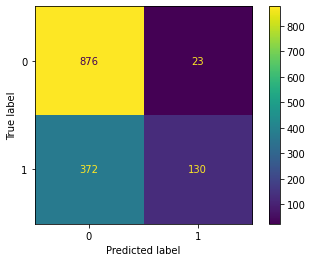

In [21]:
plot_confusion_matrix(cl, tfidf_X_test.toarray(), tfidf_y_test)
plt.show()

In [22]:
print("Regressão Logísitca e TF-IDF\nAcurácia: {}\nPrecisão: {}\nRecall: {}\nF1 Score':{}\n".format(accuracy_score(tfidf_y_test, tfidf_y_pred), precision_score(tfidf_y_test, tfidf_y_pred), recall_score(tfidf_y_test, tfidf_y_pred), f1_score(tfidf_y_test, tfidf_y_pred)))

Regressão Logísitca e TF-IDF
Acurácia: 0.7180585296216988
Precisão: 0.8496732026143791
Recall: 0.2589641434262948
F1 Score':0.3969465648854962



In [23]:
#regressão logística com countvectorizer
cl = LogisticRegression().fit(count_X_train.toarray(), count_y_train)
count_y_pred = cl.predict(count_X_test.toarray())

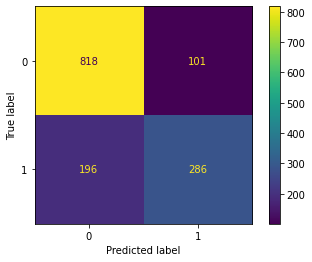

In [24]:
plot_confusion_matrix(cl, count_X_test.toarray(), count_y_test)
plt.show()

In [25]:
print("Regressão Logísitca e CountVectorizer\nAcurácia: {}\nPrecisão: {}\nRecall: {}\nF1 Score':{}\n".format(accuracy_score(count_y_test, count_y_pred), precision_score(count_y_test, count_y_pred), recall_score(count_y_test, count_y_pred), f1_score(count_y_test, count_y_pred)))

Regressão Logísitca e CountVectorizer
Acurácia: 0.7880085653104925
Precisão: 0.7390180878552972
Recall: 0.5933609958506224
F1 Score':0.6582278481012659



SVM, Redes neurais, LSTM

**Referências**

[Basics of CountVectorizer](https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c)

[TF-IDF Vectorizer scikit-learn](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a)

[Cosine Similarity – Understanding the math and how it works (with python codes)](https://www.machinelearningplus.com/nlp/cosine-similarity/)

[Split Your Dataset With scikit-learn's train_test_split()](https://realpython.com/train-test-split-python-data/)